In [6]:
using PyPlot
using JuMP, Ipopt

In [7]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");

In [8]:
dt = 1.
t = Array(2020:dt:2200);

ECS=3.0

GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.025 # ρ (relative low value from Stern review)

# Control technology cost scales (for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.02*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0.,
    baseline_emissions(t, 5., 2080., 40.)
);

In [9]:
ensemble = Dict{String, ClimateModel}();

name = "2020";
controls = init_zero_controls(t);
present_year = 2020.

model = ClimateModel(name, ECS, t, dt, controls, economics, present_year);

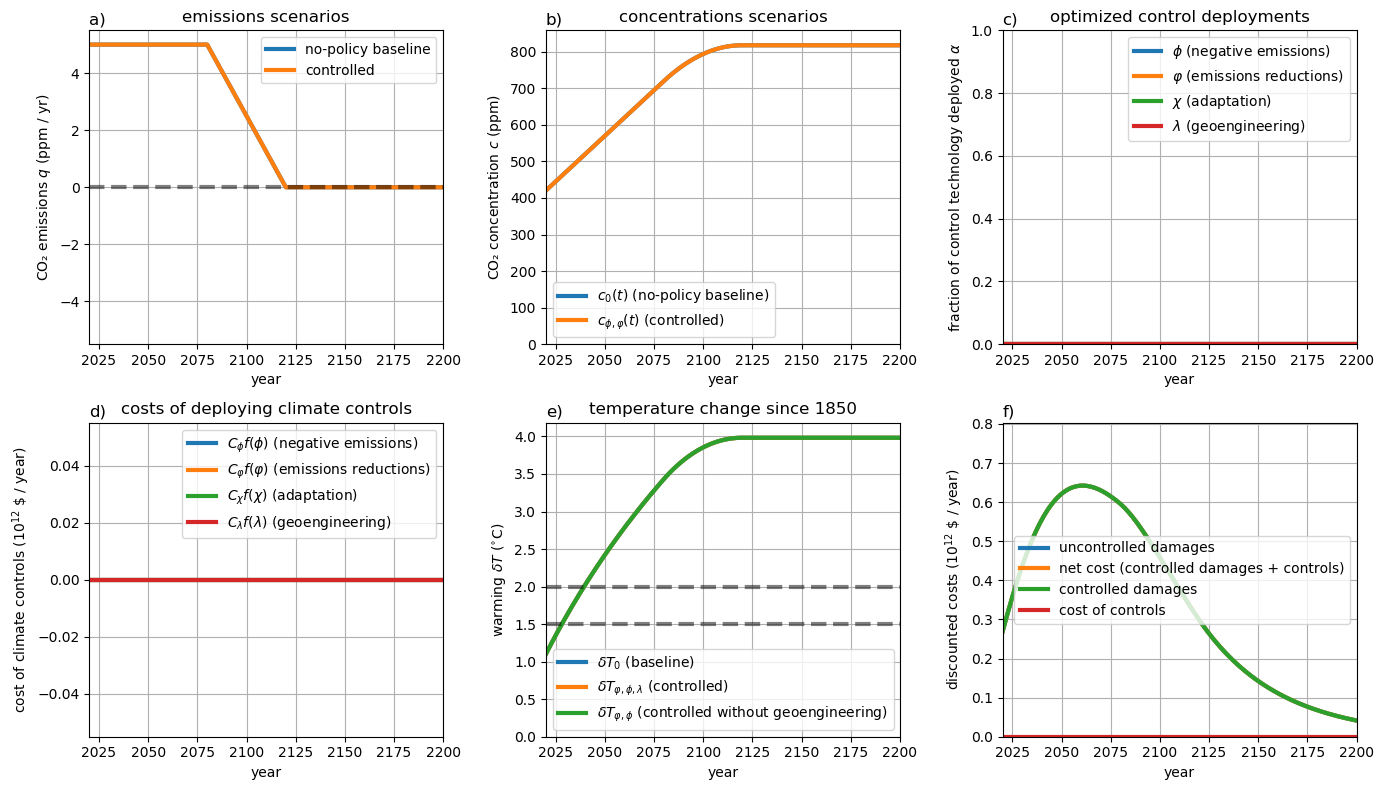

In [10]:
plot_state(model);

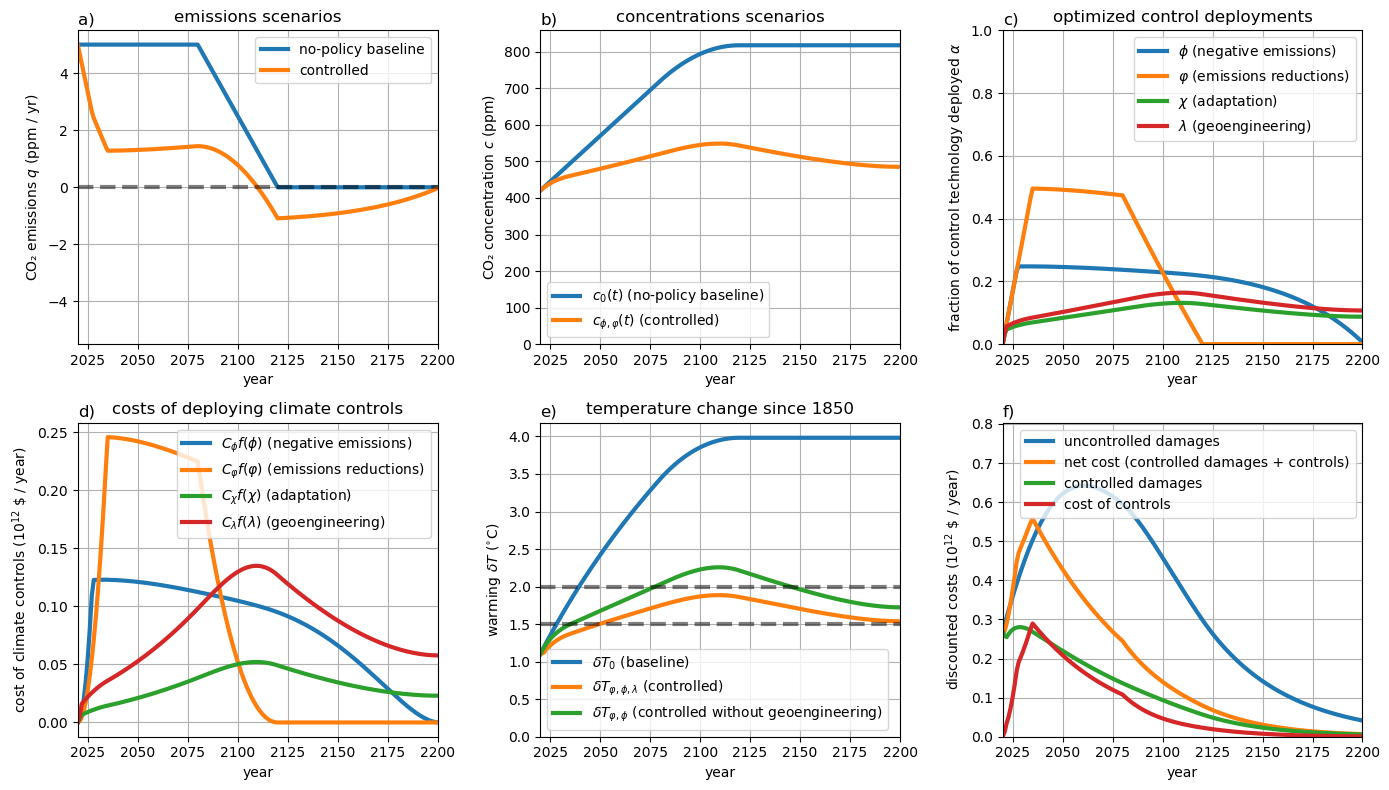

Found optimal solution for model name: 2020

In [15]:
optimize_controls!(model);
ensemble[model.name] = model;
plot_state(model);
savefig("../figures/model_state_example_policy-update-$(Int(model.present_year)).png", bbox_inches="tight", dpi=100)

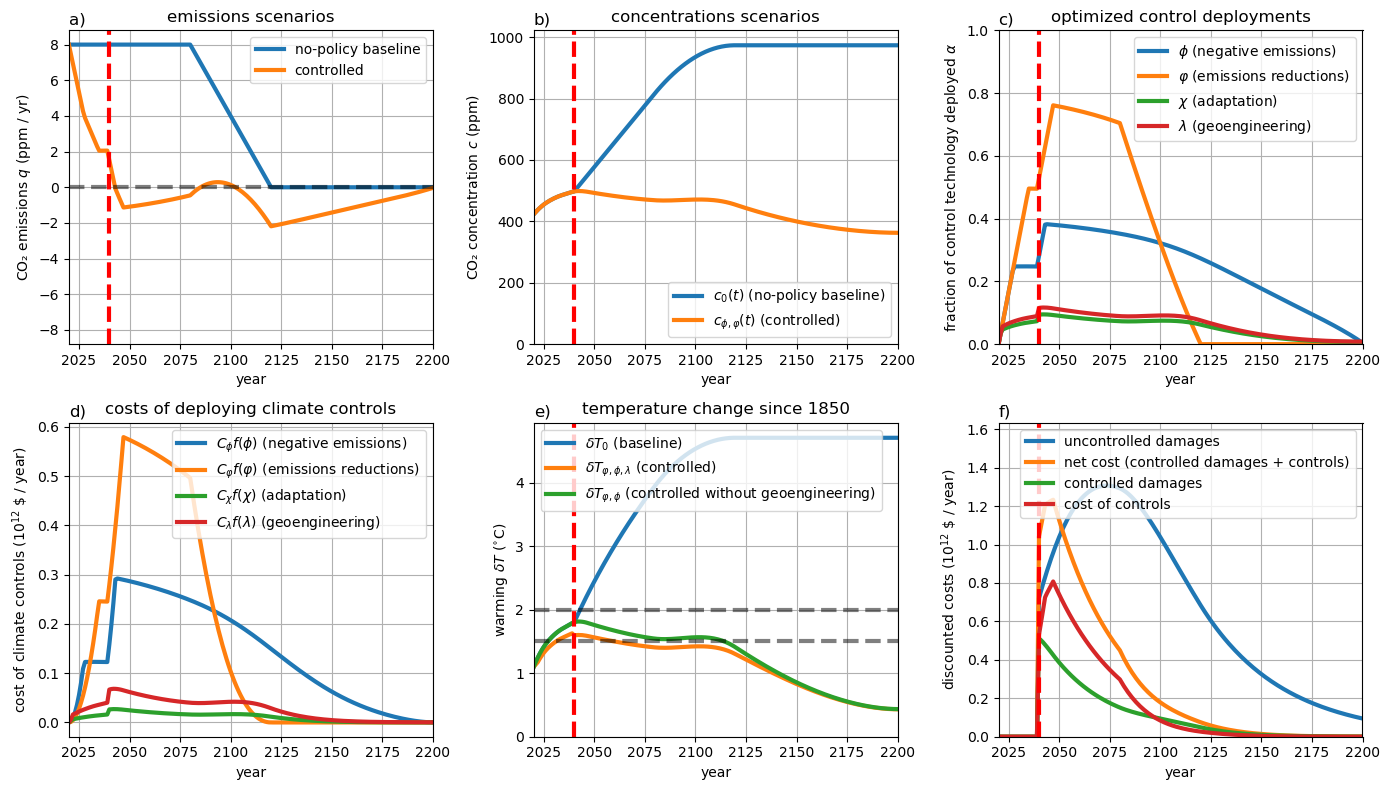

Found optimal solution for model name: 2040

In [16]:
model = step_forward(model, 20., 8., 2080., 40.)
optimize_controls!(model, maxslope = maxslope);
plot_state(model)
ensemble[model.name] = model;
savefig("../figures/model_state_example_policy-update-$(Int(model.present_year)).png", bbox_inches="tight", dpi=100)

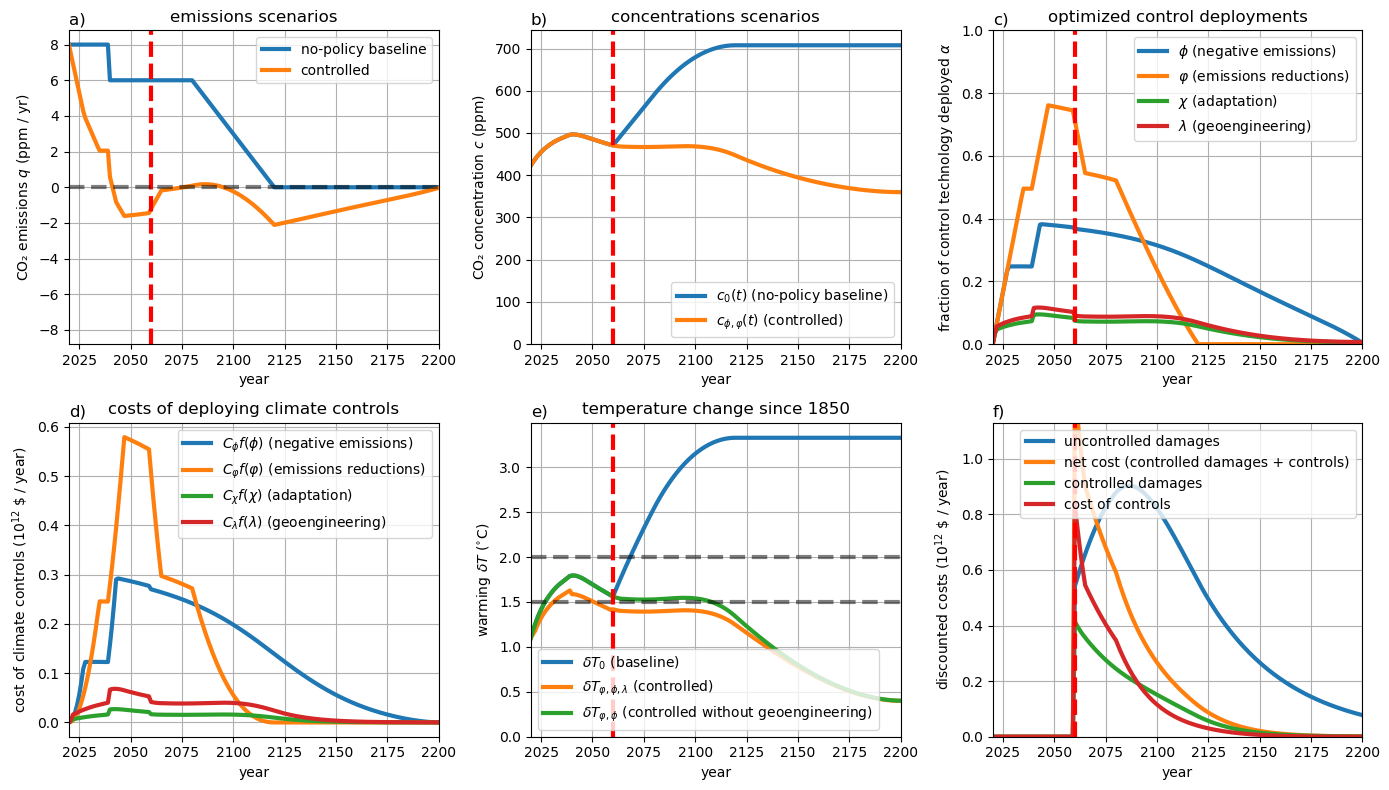

Found optimal solution for model name: 2060

In [17]:
model = step_forward(model, 20., 6., 2080., 40.)
optimize_controls!(model, maxslope = maxslope);
plot_state(model)
ensemble[model.name] = model;
savefig("../figures/model_state_example_policy-update-$(Int(model.present_year)).png", bbox_inches="tight", dpi=100)